In [1]:
%run resources.ipynb

dataset = 'IRM-Ads'
results_dir = 'Results/analysis/%s'%(dataset)
if not os.path.exists( results_dir ):
    os.makedirs( results_dir )
    
%run nns.ipynb

In [2]:
from xclib.utils.sparse import binarize
from xclib.utils.sparse import retain_topk
import random

In [3]:
RES_DIR = f'Results/{dataset}'
DATA_DIR = f'/mnt/d/nilesh/irm/Datasets/{dataset}'

In [4]:
def restrict_mat(spmat, active_rows = None, active_cols = None, shrink=False):
    if active_cols is not None and active_rows is not None:
        temp = spmat[active_rows][:,active_cols]
    elif active_rows is not None: 
        temp = spmat[active_rows]
        if shrink: 
            active_cols = np.where(temp.getnnz(0)>0)[0]
            temp = temp[:, active_cols]
    elif active_cols is not None: 
        temp = spmat[:,active_cols]
        if shrink:
            active_rows = np.where(temp.getnnz(1)>0)[0]
            temp = temp[active_rows]
    else:
        if shrink:
            active_rows = np.where(spmat.getnnz(1)>0)[0]
            active_cols = np.where(spmat.getnnz(0)>0)[0]
            temp = spmat[active_rows][:,active_cols]
        else:
            return spmat, None, None
    
    return temp, active_rows, active_cols

def get_irm_metrics(score_mat, unseen = None, fewshot=None, X_Y=None):
    if X_Y is None : X_Y = tst_X_Y
    if unseen is None : unseen = unseen_labels
    if fewshot is None : fewshot = fewshot_labels
        
    mask = np.ones(tst_X_Y.shape[1], bool); mask[unseen] = False; seen = np.where(mask)[0]
    metrics = {'GZSL' : None, 'SZSL' : None, 'XC' : None}
    
    print(_c('GZSL metrics (shape=(%d, %d)): '%(X_Y.shape[0], X_Y.shape[1]), attr='bold'))
    metrics['GZSL'] = printacc(score_mat, X_Y=X_Y, K=5, inv_prop_=inv_prop)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=fewshot, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=fewshot, shrink=True)
    print(_c('FewShot metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['FewShot'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=unseen, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=unseen, shrink=True)
    print(_c('SZSL metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['SZSL'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)
    
    temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=seen, shrink=True)
    temp_score_mat, _, _     = restrict_mat(score_mat, active_rows=active_rows, active_cols=seen, shrink=True)
    print(_c('XC metrics (shape=(%d, %d)): '%(temp_X_Y.shape[0], temp_X_Y.shape[1]), attr='bold'))
    metrics['XC'] = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=inv_prop[seen])
    
    del temp_score_mat, temp_X_Y, active_rows
    return metrics

In [5]:
def spmax(A, B):
    BisBigger = A-B
    BisBigger.data = np.where(BisBigger.data < 0, 1, 0)
    return A - A.multiply(BisBigger) + B.multiply(BisBigger)

In [6]:
import json

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import re
import nltk
import pickle as pkl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import Stemmer

def tokenizer_word(string):
    string = string.lower()
    tokens = [w for w in re.split("[\W,_]+", string) if ((len(w) > 1) and (w not in STOPWORDS))]
    tokens = stemmer.stemWords(tokens)
    return tokens

stemmer = Stemmer.Stemmer('english')

def get_xfs(vocab):
    xfs = np.empty(len(vocab), object)
    xfs[list(vocab.values())] = list(vocab.keys())
    return xfs

## Binary Readers

In [7]:
size_dict = {bool : 1, np.int32 : 4, np.float32 : 4, np.int64 : 8}

def readbuf(buf, dtype, offset=0, count=1):
    val = np.frombuffer(buf, offset=offset, dtype=dtype, count=count)
    if count == 1: val = val[0]
    offset += size_dict[dtype]*count
    return val, offset

def read_buf_bin_vecif(buf, dtype, offset = 0, totlen = -1):
    if totlen < 0: totlen, offset = readbuf(buf, np.int64, offset, 1)
    totlen *= 2
    
    temp, _ = readbuf(buf, np.int32, offset, totlen)
    inds = temp.reshape(-1, 2)[:, 0];
    temp, offset = readbuf(buf, dtype, offset, totlen)
    data = temp.reshape(-1, 2)[:, 1];
    
    nr = 1
    if inds.shape[0] > 0: nr = inds.max()+1
    return csr_matrix((data, inds, [0, len(data)]), (1, nr)), offset

def read_buf_bin_vec(buf, dtype, offset = 0, totlen = -1):
    if totlen < 0: totlen, offset = readbuf(buf, np.int64, offset, 1)
    return readbuf(buf, dtype, offset, totlen)

def read_buf_bin_spmat(buf, dtype, offset = 0, old = False):
    (nr, nc), offset = readbuf(buf, np.int32, offset, 2)
    
    size = None
    if old: size, offset = read_buf_bin_vec(buf, np.int32, offset, nr)
    else: size, offset = read_buf_bin_vec(buf, np.int32, offset)

    data = []; inds = []; indptr = np.zeros(nr+1, int)
    indptr[1:] = size.cumsum()
    totlen = indptr[-1]
    temp, offset = read_buf_bin_vecif(buf, dtype, offset, totlen)

    return csr_matrix((temp.data, temp.indices, indptr), (nr, nc)), offset

def read_bin_spmat(fname, old = False):
    buf = open(fname, 'rb').read()
    print('loaded bin file in buffer')
    spmat, _ = read_buf_bin_spmat(buf, np.float32, 0, old)
    return spmat

In [8]:
class Node:
    is_leaf = None; is_end_leaf = None; is_early_leaf = None; X_routers = None; Y_routers = None;
    depth = None; children = None; Y = None; X = None; XY = None; parent = -1;
    
    def read(self, buf, offset, ind):
        self.id = ind
            
        [self.is_leaf, self.is_early_leaf, self.is_end_leaf], offset = readbuf(buf, bool, offset, 3)
        self.depth, offset = readbuf(buf, np.int32, offset, 1)
        self.children, offset = read_buf_bin_vec(buf, np.int32, offset)
        self.X, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.Y, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.xy_inds, offset = read_buf_bin_vec(buf, np.int32, offset)
                
        if self.id == 0:
            self.XY, offset = read_buf_bin_spmat(buf, np.int32, offset)
        
        if not self.is_leaf:
            self.X_routers, offset = read_buf_bin_spmat(buf, np.float32, offset)
            self.Y_routers, offset = read_buf_bin_spmat(buf, np.float32, offset)
            
        return offset
    
    def __str__(self):
        return  f'id : {self.id}\nparent : {self.parent}\nis_leaf : {self.is_leaf}\nis_early_leaf : {self.is_early_leaf}\
                \nis_end_leaf : {self.is_end_leaf}\nchildren : {self.children}\ndepth : {self.depth}\nnnz X : {self.X.nnz}\
                \nnnz Y : {self.Y.nnz}\nnnz XY : {self.xy_inds.shape[0]}\n'

    def __repr__(self):
        return  f'id : {self.id}\nparent : {self.parent}\nis_leaf : {self.is_leaf}\nis_early_leaf : {self.is_early_leaf}\
                \nis_end_leaf : {self.is_end_leaf}\nchildren : {self.children}\ndepth : {self.depth}\nnnz X : {self.X.nnz}\
                \nnnz Y : {self.Y.nnz}\nnnz XY : {self.xy_inds.shape[0]}\n'
    
class Tree:
    numxf = None; numyf = None; numx = None; numy = None; numxy = None; nodes = None; max_depth = None;
    shared_clf = None; ova_clf = None
    
    def read(self, filename, offset=0):
        buf = open(filename, 'rb').read()
        
        [self.numxf, self.numyf, self.numx, self.numy, self.numxy, numnode], offset = readbuf(buf, np.int32, offset, 6)
        self.nodes = np.empty(numnode, dtype=object)
        
        for i in tqdm(range(numnode)):
            nodeid, offset = readbuf(buf, np.int32, offset, 1)
            self.nodes[nodeid] = Node()
            offset = self.nodes[nodeid].read(buf, offset, nodeid)
        
        self.shared_clf, offset = read_buf_bin_vecif(buf, np.float32, offset)
        self.ova_clf, offset = read_buf_bin_spmat(buf, np.float32, offset)

In [25]:
plt.style.use('seaborn')

In [6]:
trn_X_Y = read_sparse_mat('%s/trn_X_Y.txt'%DATA_DIR, use_xclib=False)

6989516it [01:19, 87736.66it/s] 


In [23]:
x, y = np.unique(trn_X_Y.getnnz(0), return_counts=True)

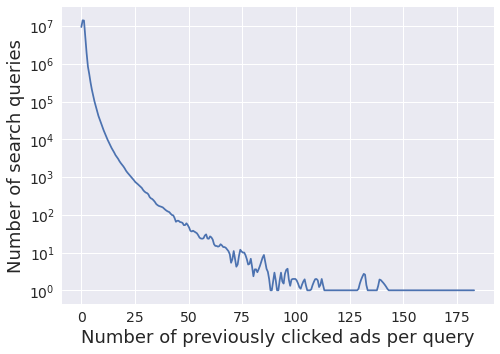

In [29]:
from scipy.interpolate import make_interp_spline, BSpline

xnew = np.linspace(x.min(), x.max(), 300) 
spl = make_interp_spline(x, y, k=1)  # type: BSpline
smooth = spl(xnew)

# from scipy.ndimage.filters import gaussian_filter1d
# ysmoothed = gaussian_filter1d(y, sigma=10)

# plt.plot(x, ysmoothed)
plt.ylabel('Number of search queries', fontsize=18)
plt.xlabel('Number of previously clicked ads per query', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.plot(xnew, smooth)
plt.yscale('log')
plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

plt.savefig('/mnt/c/Users/t-nilgup/Pictures/ads-label-frequency.png', facecolor='w')
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/ads-label-frequency.eps', facecolor='w')

plt.show()

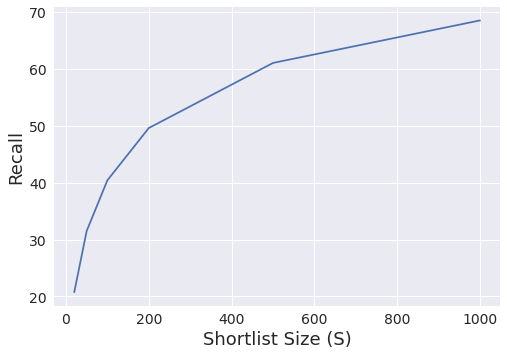

In [41]:
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Shortlist Size (S)', fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.plot([20, 50, 100, 200, 500, 1000], [20.74, 31.5, 40.42, 49.61, 61.06, 68.54])
# plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/shortlist-ablation.png', facecolor='w')
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/shortlist-ablation.eps', facecolor='w')

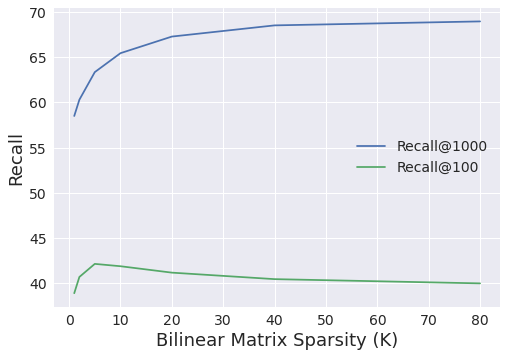

In [40]:
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Bilinear Matrix Sparsity (K)', fontsize=18)
plt.ylabel('Recall', fontsize=18)
plt.plot([1, 2, 5, 10, 20, 40, 80], [58.5, 60.30, 63.36, 65.46, 67.30, 68.54, 68.98], label='Recall@1000')
# plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
# plt.savefig('/mnt/c/Users/t-nilgup/Pictures/sparsity-vs-r1000-ablation.png', facecolor='w')
# plt.savefig('/mnt/c/Users/t-nilgup/Pictures/sparsity-vs-r1000-ablation.eps', facecolor='w')

# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel('Sparsity of bilinear generative', fontsize=18)
# plt.ylabel('Recall@100', fontsize=18)
plt.plot([1, 2, 5, 10, 20, 40, 80], [38.86, 40.66, 42.11, 41.85, 41.14, 40.42, 39.95], label='Recall@100')
plt.legend(prop={'size': 14})
# plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/sparsity-vs-recall-ablation.png', facecolor='w')
plt.savefig('/mnt/c/Users/t-nilgup/Pictures/sparsity-vs-recall-ablation.eps', facecolor='w')

## Load Data

In [7]:
val_X_Y = read_sparse_mat('%s/val_X_Y.txt'%DATA_DIR, use_xclib=True)
trn_X_Y = read_sparse_mat('%s/trn_X_Y.txt'%DATA_DIR, use_xclib=True)
tst_X_Y = read_sparse_mat('%s/tst_X_Y.txt'%DATA_DIR, use_xclib=True)
if os.path.exists('%s/pos_trn_tst.txt'%DATA_DIR): filter_mat = read_sparse_mat('%s/pos_trn_tst.txt'%DATA_DIR, use_xclib=True)
else : filter_mat = None
if os.path.exists('%s/pos_trn_val.txt'%DATA_DIR): val_filter_mat = read_sparse_mat('%s/pos_trn_val.txt'%DATA_DIR, use_xclib=True)

nnz = trn_X_Y.getnnz(0)
valid_labels = np.where(nnz > 0)[0]
unseen_labels = np.where(nnz == 0)[0]
fewshot_labels = np.where((nnz >= 0) & (nnz <= 5))[0]
inv_valid_labels = np.vectorize({v : i for i, v in enumerate(valid_labels)}.get)

if "Amazon" in dataset: A = 0.6; B = 2.6
elif "Wiki" in dataset: A = 0.5; B = 0.4
else : A = 0.55; B = 1.5
inv_prop = xc_metrics.compute_inv_propesity(trn_X_Y, A, B)

/home/t-nilgup/.local/lib/python3.7/site-packages/xclib-0.96-py3.7-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [8]:
tst_X_Xf = read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt')

/home/nilesh/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-linux-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [9]:
trn_X_Xf = read_bin_spmat(f'{DATA_DIR}/trn_X_Xf.txt.bin').copy()

loaded bin file in buffer


In [10]:
trn_X = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]
Y = [x.split(';', 1)[0].strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]
tst_X = [x.strip() for x in open(f'{DATA_DIR}/raw/tst_X.txt').readlines()]

In [41]:
xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt').readlines()]

In [16]:
print(get_text(0, xfs, trn_X_Xf))

x = 0 : 
idealo(15.54, 1718719) barbless(14.55, 881798) tackl(7.98, 916212) 438(7.02, 1389936) charg(6.04, 1373095) hook(5.82, 1206959) eye(5.34, 991918) 628(5.26, 1220673) catch(5.22, 669616) deaf(4.54, 200634) estuari(4.36, 415471) jlsporteu(3.77, 653173) tone(2.85, 617783) big(2.75, 839440) comparison(2.47, 926405) msc(2.27, 933136) bait(2.24, 1158769) fish(2.19, 1418374) 252(1.80, 44205) 769(1.79, 281800) interim(1.68, 1441966) marketplac(1.64, 1444013) luxembourg(1.56, 932176) 1846(1.50, 236564) 355(1.42, 280242) fladen(1.39, 1632124) cost(1.30, 585037) 812(1.21, 3756) rank(1.19, 187808) sterl(1.17, 424673) keenet(1.16, 1506324) pound(1.12, 336694) foxrac(1.09, 138346) gibson(1.09, 737142) hobbyhom(1.09, 1569424) advancedanglingsolut(1.07, 944991) dynamicnakedaudio(1.05, 8434) quay(1.03, 1212250) stewart(0.98, 1277935) express(0.97, 757470) 339(0.92, 856938) mustad(0.91, 996959) compar(0.87, 1203212) okuma(0.87, 1658534) ideal(0.85, 439226) korum(0.84, 824496) vat(0.83, 1428781) s

In [11]:
sp_pattern_mat = read_bin_spmat(f'{RES_DIR}/model/sparsity_pattern.bin')
trn_X_Xf = read_sparse_mat(f'{DATA_DIR}/trn_X_Xf.txt')
tst_X_Xf = read_sparse_mat(f'{DATA_DIR}/tst_X_Xf.txt')
val_X_Xf = read_sparse_mat(f'{DATA_DIR}/val_X_Xf.txt')
Y_Yf = read_sparse_mat(f'{DATA_DIR}/Y_Yf.txt')

xfs = [x.strip() for x in open(f'{DATA_DIR}/Xf.txt').readlines()]
yfs = [x.strip() for x in open(f'{DATA_DIR}/Yf.txt').readlines()]
trn_X = [x.strip() for x in open(f'{DATA_DIR}/raw/trn_X.txt').readlines()]
Y = [x.split(';', 1)[0].strip() for x in open(f'{DATA_DIR}/raw/Y.txt').readlines()]
tst_X = [x.strip() for x in open(f'{DATA_DIR}/raw/tst_X.txt').readlines()]
val_X = [x.strip() for x in open(f'{DATA_DIR}/raw/val_X.txt').readlines()]

loaded bin file in buffer


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/nilesh/Datasets/IRM-Ads/raw/val_X.txt'

In [9]:
k=100000

inds = np.random.choice(range(tst_X_Xf.shape[0]), size=k, replace=False)
np.save(f'{DATA_DIR}/random{k}_tst_inds.npy', inds)
write_sparse_mat(tst_X_Xf[inds], f'{DATA_DIR}/random{k}_tst_X_Xf.txt')
write_sparse_mat(tst_X_Y[inds], f'{DATA_DIR}/random{k}_tst_X_Y.txt')

# inds = np.random.choice(range(trn_X_Xf.shape[0]), size=k, replace=False)
# np.save(f'{DATA_DIR}/random{k}_trn_inds.npy', inds)
# write_sparse_mat(trn_X_Xf[inds], f'{DATA_DIR}/random{k}_trn_X_Xf.txt')
# write_sparse_mat(trn_X_Y[inds], f'{DATA_DIR}/random{k}_trn_X_Y.txt')

In [35]:
write_sparse_mat(filter_mat[inds], f'{DATA_DIR}/random{k}_pos_trn_tst.txt')

## Featurization

In [51]:
part_tst_data = pd.read_csv(f'{DATA_DIR}/raw/Raw_tst_X_features.txt', sep='\t', names=['id', 'type', 'text'], quoting=3)

cross_part_tst_data = pd.crosstab(index=part_tst_data['id'],columns=part_tst_data['type'],values=part_tst_data['text'], aggfunc=np.sum).fillna('')
cross_part_tst_data.to_pickle(f'{DATA_DIR}/raw/cross_part_tst_data.pkl')

cross_part_tst_data['all'] = cross_part_tst_data.apply(lambda x: '; '.join([x['Title'], x['VisualHeading'], x['ImgAltTxt'], x['QISnippet'], x['Content']]), axis=1)

f1 = open(f'{DATA_DIR}/raw/part_raw_tst_X.txt', 'w')
f2 = open(f'{DATA_DIR}/raw/part_raw_4096_tst_X.txt', 'w')
for s in tqdm(cross_part_tst_data['all'].values):
    print(s, file=f1)
    print(s[:4096], file=f2)

In [78]:
tst_data = pd.read_csv(f'{DATA_DIR}/raw/tst_X.txt', sep='\t', names=['id', 'url'], quoting=3)
tst_data['ind'] = np.arange(tst_data.shape[0])

part_ids = pd.DataFrame({'id': cross_part_tst_data.index})
temp = part_ids.merge(tst_data[['id', 'ind']], on='id')

np.save(f'{DATA_DIR}/raw/part_ids.npy', temp.ind.values) 

In [31]:
vectorizer = TfidfVectorizer(tokenizer=tokenizer_word, ngram_range=(2, 2), max_df=0.5, max_features=1000000, norm=None)
bi_X_Xf = vectorizer.fit_transform(trn_X)

bi_xfs = get_xfs(vectorizer.vocabulary_)
print(len(bi_xfs))

1000000


In [33]:
bi_tst_X_Xf = vectorizer.transform(tst_X)

In [39]:
i = random.randrange(len(trn_X))
print(trn_X[i], get_text(i, bi_xfs, bi_X_Xf))

D70535CF010F16715727	http://www.amazon.co.uk/s/?ie=UTF8&keywords=fresh+prince+shirt&tag=mh0a9-21&index=aps&hvadid=&hvqmt=&hvbmt=&hvdev=&ref=pd_sl_6tiogge5nd_b x = 3457355 : 
princ shirt(14.81, 727054) fresh princ(13.67, 370712) keyword fresh(10.22, 512566) shirt tag(6.95, 809282) mh0a9 21(1.73, 613345) tag mh0a9(1.73, 867306) ap hvadid(1.72, 88500) index ap(1.72, 466692)


In [43]:
new_xfs = np.hstack([xfs, bi_xfs])
new_trn_X_Xf = normalize(sp.hstack([normalize(trn_X_Xf, axis=1), normalize(bi_X_Xf, axis=1)]).tocsr(), axis=1)
new_tst_X_Xf = normalize(sp.hstack([normalize(tst_X_Xf, axis=1), normalize(bi_tst_X_Xf, axis=1)]).tocsr(), axis=1)

In [44]:
print('\n'.join(new_xfs), file=open(f'{DATA_DIR}/new_Xf.txt', 'w'))
sp.save_npz(f'{DATA_DIR}/new_trn_X_Xf.npz', new_trn_X_Xf)
sp.save_npz(f'{DATA_DIR}/new_tst_X_Xf.npz', new_tst_X_Xf)
write_sparse_mat(new_trn_X_Xf, f'{DATA_DIR}/new_trn_X_Xf.txt')
write_sparse_mat(new_tst_X_Xf, f'{DATA_DIR}/new_tst_X_Xf.txt')

In [55]:
i = random.randrange(len(trn_X))
print(trn_X[i], get_text(i, new_xfs, new_trn_X_Xf), sep='\n\n')

3AB9E73270D93241912E	http://www.amazon.co.uk/s/?ie=UTF8&keywords=m18+light&tag=mh0a9-21&index=aps&hvadid=&hvqmt=&hvbmt=&hvdev=&ref=pd_sl_2obkf0ab1a_b

x = 6112300 : 
m18 light(0.50, 2402582) milwauke(0.44, 462897) keyword m18(0.44, 2334888) m18(0.41, 1187617) light tag(0.22, 2385521) nake(0.14, 164081) batteri(0.10, 1798055) charger(0.10, 840475) led(0.10, 184133) m12(0.09, 398447) torch(0.09, 873844) m12al(0.06, 526312) 4933459440(0.06, 1539676) m18il(0.06, 1656893) miwauke(0.06, 1550952) m18ll(0.06, 483720) m18al(0.06, 441089) 4933464124(0.06, 473150) m12bi(0.06, 1358087) m12tled(0.06, 99031) m18b2(0.06, 761553) mh0a9 21(0.06, 2426959) tag mh0a9(0.06, 2680920) ap hvadid(0.06, 1902114) index ap(0.06, 2280306) m18tled(0.05, 932237) c12hz(0.05, 1436888) hackzal(0.05, 1312912) m18bmt(0.05, 504798) bpp2c(0.05, 1223696) lantern(0.05, 888850) 402c(0.05, 1241016) illumin(0.04, 1548346) rover(0.04, 1553868) degre(0.04, 1587860) ipl(0.04, 1634171) xxx(0.03, 85089) 360(0.03, 1368362) 0ah(0.03, 

In [66]:
inds = np.load(f'{DATA_DIR}/random100000_tst_inds.npy')

In [67]:
rand_tst_X_Xf = new_tst_X_Xf[inds]
write_sparse_mat(rand_tst_X_Xf, f'{DATA_DIR}/random100000_tst_X_Xf.txt')

In [64]:
tst_X[val_inds[0]]

'64BFC75AA0ED304B4662\thttps://www.ebay.co.uk/ulk/sch/?_nkw=revision guide maths edexcel'

In [63]:
print(get_text(0, new_xfs, val_X_Xf))

x = 0 : 
edexcel(0.42, 244090) guid math(0.38, 2231284) revis(0.36, 1297648) math edexcel(0.35, 2417160) gcse(0.30, 758302) revis guid(0.27, 2579151) math(0.26, 548166) uk ulk(0.17, 2742153) sch nkw(0.17, 2603427) ulk sch(0.17, 2743461) ebay co(0.17, 2126912) www ebay(0.17, 2795971) higher(0.11, 1654548) https www(0.07, 2268805) mathemat(0.06, 1145380) foundat(0.06, 1184113) cgp(0.05, 1074560) workbook(0.05, 1663978) grade(0.03, 758640) exam(0.03, 1353989) tier(0.03, 18819) postag(0.03, 892097) collin(0.02, 926362) parson(0.02, 1701429) ocr(0.02, 378617) aqa(0.02, 1350002) resit(0.02, 1639066) level(0.02, 162576) own(0.02, 635288) practic(0.02, 742858) flashcard(0.02, 1759261) pre(0.01, 977614) evor(0.01, 1076754) cours(0.01, 1416437) spec(0.01, 253484) edex(0.01, 51507) achiev(0.01, 1584398) seni(0.01, 466404) richard(0.01, 722183) practi(0.01, 1488835) senior(0.01, 487815) success(0.01, 1128735) hig(0.01, 1313221) gwen(0.01, 908129) pra(0.01, 208520) textbook(0.01, 681474) editio(0.0

3254839

## Load tree

In [218]:
tree = Tree()
tree.read(f'{RES_DIR}/0.tree.bin')

early_leaf_nodes = [i for i in range(tree.nodes.shape[0]) if tree.nodes[i].is_early_leaf]
end_leaf_nodes = [i for i in range(tree.nodes.shape[0]) if tree.nodes[i].is_end_leaf]

for i, node in enumerate(tree.nodes):
    for child in node.children:
        tree.nodes[child].parent = i

data = []
inds = []
indptr = [0]
for node in tqdm(tree.nodes):
    data.append(node.Y.data)
    inds.append(node.Y.indices)
    indptr.append(indptr[-1]+node.Y.nnz)
node_to_label = csr_matrix((np.hstack(data), np.hstack(inds), indptr), (tree.nodes.shape[0], tree.numy))

100%|██████████| 2791/2791 [00:00<00:00, 531669.66it/s]


## Evaluate

In [8]:
all_metrics = {}

In [18]:
val_score_mats = {}
val_score_mats['clf'] = _filter(read_bin_spmat(f'{RES_DIR}/validation/clf_score_mat.bin').copy(), val_filter_mat)
val_score_mats['bil'] = _filter(read_bin_spmat(f'{RES_DIR}/validation/bilinear_score_mat.bin').copy(), val_filter_mat)
val_score_mats['knn'] = _filter(read_bin_spmat(f'{RES_DIR}/validation/knn_score_mat.bin').copy(), val_filter_mat)
val_score_mats['xsh'] = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/validation/shortlist.bin').copy(), val_filter_mat), k=100)

loaded bin file in buffer


/home/t-nilgup/anaconda3/envs/xc/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [21]:
wts = {'clf': 0.1, 'bil': 0.7, 'knn': 0.2, 'xsh': 0}
score_mat = retain_topk(wts['clf']*val_score_mats['clf'] + wts['bil']*val_score_mats['bil'] + wts['knn']*val_score_mats['knn'] + wts['xsh']*val_score_mats['xsh'], k=300)

In [30]:
metrics = get_irm_metrics(val_score_mats['xsh'], X_Y=val_X_Y);
myprint(*metrics['GZSL'][0, [0, 2, 4]], *metrics['FewShot'][0, [0, 2, 4]], *metrics['SZSL'][0, [0, 2, 4]], *metrics['GZSL'][2, [0, 2, 4]])

GZSL metrics (shape=(100000, 31476574)): 


,1,2,3,4,5
P,10.23,8.85,7.71,6.84,6.14
nDCG,10.23,13.23,15.14,16.41,17.30
PSP,9.97,13.60,15.97,17.65,18.89
PSnDCG,9.97,12.98,14.90,16.18,17.08


FewShot metrics (shape=(96966, 31149553)): 


,1,2,3,4,5
P,11.21,9.39,8.01,6.98,6.2
nDCG,11.21,14.29,16.14,17.30,18.1


SZSL metrics (shape=(74347, 9525826)): 


,1,2,3,4,5
P,20.84,14.50,11.51,9.71,8.51
nDCG,20.84,23.32,24.88,25.96,26.80


XC metrics (shape=(40813, 21950748)): 


,1,2,3,4,5
P,12.56,10.43,8.79,7.62,6.68
nDCG,12.56,16.35,18.56,19.99,20.88
PSP,12.18,16.56,19.18,21.00,22.14
PSnDCG,12.18,16.03,18.27,19.72,20.63


10.23 7.71 6.14 11.21 8.01 6.20 20.84 11.51 8.51 9.97 15.97 18.89


In [69]:
rand_inds = np.load(f'{DATA_DIR}/random100000_tst_inds.npy')

In [70]:
tst_clf_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/clf_score_mat.bin').copy(), filter_mat[rand_inds]), k=100)
tst_bilinear_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy(), filter_mat[rand_inds]), k=100)
tst_knn_score_mat = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy(), filter_mat[rand_inds]), k=100)

# # trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
tst_xshortlist = retain_topk(_filter(read_bin_spmat(f'{RES_DIR}/shortlist.bin').copy(), filter_mat[rand_inds]), k=100)

loaded bin file in buffer


/home/nilesh/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [156]:
temp = retain_topk(_filter(read_bin_spmat(f'/mnt/c/nilesh/zestxml/bm25/Results/IRM-Ads/score_mat.bin').copy(), filter_mat[rand_inds[:10000]]), k=100)

loaded bin file in buffer


/home/nilesh/.local/lib/python3.6/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [71]:
score_mat = 0.1*tst_clf_score_mat + 0.85*tst_bilinear_score_mat + 0.05*tst_knn_score_mat

In [77]:
recall(tst_bilinear_score_mat, X_Y=tst_X_Y[rand_inds])

{'R@1': 7.761797442064967,
 'R@10': 31.46745451076256,
 'R@50': 47.14505407591766,
 'R@100': 52.89161789706527}

In [74]:
recall(tst_knn_score_mat, X_Y=tst_X_Y[rand_inds])

{'R@1': 13.312228974237318,
 'R@10': 28.291712006327163,
 'R@50': 41.787933653429945,
 'R@100': 47.98941099815238}

In [157]:
metrics = get_irm_metrics(temp, X_Y=tst_X_Y[rand_inds[:10000]]);

GZSL metrics (shape=(10000, 31476574)): 


,1,2,3,4,5
P,3.71,3.20,2.86,2.57,2.34
nDCG,3.71,4.83,5.65,6.21,6.65
PSP,3.73,5.07,6.08,6.81,7.39
PSnDCG,3.73,4.87,5.70,6.27,6.72


FewShot metrics (shape=(9713, 31149553)): 


,1,2,3,4,5
P,3.82,3.32,2.95,2.65,2.41
nDCG,3.82,5.00,5.83,6.40,6.86


SZSL metrics (shape=(7480, 9525826)): 


,1,2,3,4,5
P,7.82,6.27,5.10,4.48,3.95
nDCG,7.82,9.74,10.69,11.52,12.03


XC metrics (shape=(4041, 21950748)): 


,1,2,3,4,5
P,3.44,2.85,2.49,2.15,1.93
nDCG,3.44,4.62,5.41,5.84,6.22
PSP,3.52,4.75,5.70,6.23,6.72
PSnDCG,3.52,4.75,5.58,6.03,6.41


In [72]:
metrics = get_irm_metrics(score_mat, X_Y=tst_X_Y[rand_inds]);

GZSL metrics (shape=(100000, 31476574)): 


,1,2,3,4,5
P,15.45,11.98,9.70,8.18,7.12
nDCG,15.45,18.62,20.25,21.23,21.91
PSP,15.22,18.58,20.24,21.25,22.01
PSnDCG,15.22,18.44,20.09,21.08,21.77


FewShot metrics (shape=(96966, 31149553)): 


,1,2,3,4,5
P,16.21,12.14,9.65,8.09,7.03
nDCG,16.21,19.18,20.63,21.54,22.21


SZSL metrics (shape=(74347, 9525826)): 


,1,2,3,4,5
P,23.24,15.86,12.38,10.31,8.92
nDCG,23.24,25.66,27.10,28.06,28.75


XC metrics (shape=(40813, 21950748)): 


,1,2,3,4,5
P,16.80,12.66,10.00,8.24,7.06
nDCG,16.80,20.59,22.40,23.40,24.09
PSP,16.51,20.31,22.03,22.91,23.57
PSnDCG,16.51,20.42,22.27,23.30,24.01


In [52]:
X_Y = tst_X_Y[rand_inds]

In [63]:
best_score_mat = score_mat
best_p5 = 0
active_labels = unseen_labels
temp_X_Y, active_rows, _ = restrict_mat(X_Y, active_rows=None, active_cols=active_labels, shrink=True)

for alpha in tqdm(drange(0, 1, 0.1)):
    for beta in drange(0, alpha+0.00001, 0.1):
        gamma = 1-alpha-beta
        print(alpha, beta, gamma)
        combined = retain_topk(alpha*tst_knn_score_mat + beta*tst_bilinear_score_mat + gamma*tst_xshortlist, k=100, copy=False)
        temp_score_mat, _, _ = restrict_mat(combined, active_rows=active_rows, active_cols=active_labels, shrink=True)
        temp_metrics = printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None, disp=True)
        if temp_metrics[0, 4] > best_p5:
            best_p5 = temp_metrics[0, 4]
            best_score_mat = combined
    _score_mat = best_score_mat

0it [00:00, ?it/s]

0.0 0.0 1.0


,1,2,3,4,5
P,11.6,8.33,6.68,5.67,5.00
nDCG,11.6,13.26,14.27,14.98,15.54


1it [00:03,  3.24s/it]

0.1 0.0 0.9


,1,2,3,4,5
P,11.44,8.12,6.45,5.44,4.77
nDCG,11.44,13.04,14.00,14.66,15.17


0.1 0.1 0.8


,1,2,3,4,5
P,11.61,8.23,6.57,5.53,4.86
nDCG,11.61,13.19,14.18,14.83,15.35


2it [00:10,  4.47s/it]

0.2 0.0 0.8


,1,2,3,4,5
P,11.38,8.06,6.39,5.39,4.73
nDCG,11.38,12.97,13.90,14.56,15.08


0.2 0.1 0.7000000000000001


,1,2,3,4,5
P,11.51,8.14,6.47,5.45,4.78
nDCG,11.51,13.08,14.04,14.69,15.20


0.2 0.2 0.6000000000000001


,1,2,3,4,5
P,11.58,8.21,6.54,5.50,4.82
nDCG,11.58,13.16,14.13,14.77,15.28


3it [00:21,  6.38s/it]

0.3 0.0 0.7


,1,2,3,4,5
P,11.33,8.02,6.35,5.35,4.70
nDCG,11.33,12.91,13.84,14.50,15.02


0.3 0.1 0.6


,1,2,3,4,5
P,11.43,8.08,6.41,5.41,4.74
nDCG,11.43,12.99,13.93,14.59,15.11


0.3 0.2 0.49999999999999994


,1,2,3,4,5
P,11.51,8.13,6.47,5.45,4.78
nDCG,11.51,13.07,14.03,14.68,15.19


0.3 0.3 0.39999999999999997


,1,2,3,4,5
P,11.54,8.18,6.51,5.49,4.81
nDCG,11.54,13.12,14.08,14.74,15.24


4it [00:35,  8.69s/it]

0.4 0.0 0.6


,1,2,3,4,5
P,11.32,8.00,6.34,5.34,4.69
nDCG,11.32,12.89,13.82,14.48,14.99


0.4 0.1 0.5


,1,2,3,4,5
P,11.4,8.05,6.39,5.38,4.72
nDCG,11.4,12.96,13.90,14.55,15.07


0.4 0.2 0.39999999999999997


,1,2,3,4,5
P,11.45,8.09,6.43,5.42,4.75
nDCG,11.45,13.01,13.97,14.62,15.13


0.4 0.3 0.3


,1,2,3,4,5
P,11.5,8.12,6.46,5.45,4.78
nDCG,11.5,13.06,14.02,14.67,15.18


0.4 0.4 0.19999999999999996


,1,2,3,4,5
P,11.52,8.16,6.49,5.47,4.80
nDCG,11.52,13.10,14.06,14.71,15.21


5it [00:52, 11.33s/it]

0.5 0.0 0.5


,1,2,3,4,5
P,11.31,7.98,6.33,5.33,4.68
nDCG,11.31,12.87,13.80,14.46,14.97


0.5 0.1 0.4


,1,2,3,4,5
P,11.36,8.02,6.37,5.37,4.71
nDCG,11.36,12.92,13.87,14.52,15.03


0.5 0.2 0.3


,1,2,3,4,5
P,11.41,8.06,6.40,5.39,4.73
nDCG,11.41,12.97,13.92,14.57,15.09


0.5 0.3 0.2


,1,2,3,4,5
P,11.47,8.09,6.43,5.42,4.75
nDCG,11.47,13.02,13.97,14.62,15.14


0.5 0.4 0.09999999999999998


,1,2,3,4,5
P,11.49,8.12,6.46,5.45,4.78
nDCG,11.49,13.06,14.01,14.67,15.18


0.5 0.5 0.0


,1,2,3,4,5
P,11.52,8.16,6.49,5.47,4.79
nDCG,11.52,13.09,14.05,14.70,15.21


6it [01:14, 14.38s/it]

0.6 0.0 0.4


,1,2,3,4,5
P,11.3,7.98,6.32,5.33,4.67
nDCG,11.3,12.86,13.79,14.44,14.96


0.6 0.1 0.30000000000000004


,1,2,3,4,5
P,11.35,8.01,6.36,5.35,4.70
nDCG,11.35,12.91,13.84,14.50,15.01


0.6 0.2 0.2


,1,2,3,4,5
P,11.39,8.04,6.39,5.38,4.72
nDCG,11.39,12.95,13.89,14.54,15.05


0.6 0.3 0.10000000000000003


,1,2,3,4,5
P,11.42,8.07,6.41,5.40,4.74
nDCG,11.42,12.99,13.93,14.58,15.10


0.6 0.4 0.0


,1,2,3,4,5
P,11.47,8.10,6.43,5.42,4.76
nDCG,11.47,13.02,13.97,14.62,15.14


0.6 0.5 -0.09999999999999998


,1,2,3,4,5
P,11.48,8.12,6.46,5.44,4.77
nDCG,11.48,13.05,14.00,14.66,15.16


0.6 0.6 -0.19999999999999996


,1,2,3,4,5
P,11.5,8.15,6.48,5.46,4.78
nDCG,11.5,13.08,14.03,14.68,15.19


7it [01:38, 17.39s/it]

0.7000000000000001 0.0 0.29999999999999993


,1,2,3,4,5
P,11.3,7.97,6.31,5.32,4.67
nDCG,11.3,12.85,13.78,14.44,14.95


0.7000000000000001 0.1 0.19999999999999993


,1,2,3,4,5
P,11.33,7.99,6.34,5.34,4.69
nDCG,11.33,12.89,13.82,14.48,14.99


0.7000000000000001 0.2 0.09999999999999992


,1,2,3,4,5
P,11.37,8.02,6.37,5.36,4.71
nDCG,11.37,12.92,13.86,14.51,15.03


0.7000000000000001 0.3 -5.551115123125783e-17


,1,2,3,4,5
P,11.41,8.05,6.39,5.39,4.72
nDCG,11.41,12.97,13.91,14.56,15.07


0.7000000000000001 0.4 -0.10000000000000009


,1,2,3,4,5
P,11.43,8.07,6.41,5.40,4.74
nDCG,11.43,12.99,13.93,14.58,15.09


0.7000000000000001 0.5 -0.20000000000000007


,1,2,3,4,5
P,11.46,8.09,6.43,5.42,4.75
nDCG,11.46,13.02,13.96,14.62,15.13


0.7000000000000001 0.6 -0.30000000000000004


,1,2,3,4,5
P,11.48,8.12,6.45,5.44,4.77
nDCG,11.48,13.05,14.00,14.65,15.15


0.7000000000000001 0.7000000000000001 -0.40000000000000013


,1,2,3,4,5
P,11.49,8.14,6.47,5.45,4.77
nDCG,11.49,13.07,14.02,14.67,15.17


8it [02:07, 20.72s/it]

0.8 0.0 0.19999999999999996


,1,2,3,4,5
P,11.28,7.96,6.31,5.32,4.66
nDCG,11.28,12.84,13.77,14.42,14.94


0.8 0.1 0.09999999999999995


,1,2,3,4,5
P,11.32,7.98,6.33,5.34,4.68
nDCG,11.32,12.87,13.81,14.46,14.97


0.8 0.2 -5.551115123125783e-17


,1,2,3,4,5
P,11.35,8.02,6.35,5.35,4.70
nDCG,11.35,12.91,13.84,14.49,15.01


0.8 0.3 -0.10000000000000003


,1,2,3,4,5
P,11.38,8.04,6.38,5.38,4.71
nDCG,11.38,12.94,13.88,14.53,15.04


0.8 0.4 -0.20000000000000007


,1,2,3,4,5
P,11.41,8.06,6.40,5.39,4.72
nDCG,11.41,12.97,13.91,14.56,15.07


0.8 0.5 -0.30000000000000004


,1,2,3,4,5
P,11.44,8.08,6.41,5.40,4.74
nDCG,11.44,12.99,13.94,14.58,15.09


0.8 0.6 -0.4


,1,2,3,4,5
P,11.45,8.09,6.43,5.42,4.75
nDCG,11.45,13.01,13.96,14.61,15.12


0.8 0.7000000000000001 -0.5000000000000001


,1,2,3,4,5
P,11.48,8.12,6.44,5.43,4.76
nDCG,11.48,13.04,13.98,14.64,15.14


0.8 0.8 -0.6000000000000001


,1,2,3,4,5
P,11.49,8.13,6.46,5.45,4.77
nDCG,11.49,13.06,14.00,14.66,15.16


9it [02:39, 24.03s/it]

0.9 0.0 0.09999999999999998


,1,2,3,4,5
P,11.27,7.96,6.30,5.31,4.66
nDCG,11.27,12.83,13.76,14.41,14.93


0.9 0.1 -2.7755575615628914e-17


,1,2,3,4,5
P,11.31,7.98,6.32,5.33,4.67
nDCG,11.31,12.87,13.80,14.45,14.96


0.9 0.2 -0.10000000000000003


,1,2,3,4,5
P,11.33,8.00,6.35,5.35,4.69
nDCG,11.33,12.89,13.83,14.48,14.99


0.9 0.3 -0.2


,1,2,3,4,5
P,11.36,8.02,6.36,5.36,4.70
nDCG,11.36,12.92,13.85,14.51,15.02


0.9 0.4 -0.30000000000000004


,1,2,3,4,5
P,11.39,8.04,6.38,5.38,4.71
nDCG,11.39,12.95,13.89,14.53,15.04


0.9 0.5 -0.4


,1,2,3,4,5
P,11.42,8.06,6.39,5.39,4.72
nDCG,11.42,12.98,13.91,14.55,15.06


0.9 0.6 -0.5


,1,2,3,4,5
P,11.43,8.08,6.41,5.40,4.74
nDCG,11.43,12.99,13.93,14.58,15.09


0.9 0.7000000000000001 -0.6000000000000001


,1,2,3,4,5
P,11.46,8.10,6.43,5.42,4.75
nDCG,11.46,13.02,13.96,14.61,15.11


0.9 0.8 -0.7000000000000001


,1,2,3,4,5
P,11.47,8.12,6.44,5.43,4.76
nDCG,11.47,13.04,13.98,14.63,15.14


0.9 0.9 -0.8


,1,2,3,4,5
P,11.47,8.13,6.45,5.44,4.77
nDCG,11.47,13.05,13.99,14.64,15.14


10it [03:14, 19.48s/it]


In [64]:
temp_score_mat, _, _     = restrict_mat(best_score_mat, active_rows=active_rows, active_cols=active_labels, shrink=True)
printacc(temp_score_mat, X_Y=temp_X_Y, K=5, inv_prop_=None)

,1,2,3,4,5
P,11.6,8.33,6.68,5.67,5.00
nDCG,11.6,13.26,14.27,14.98,15.54


array([[11.59562592,  8.32649603,  6.67590264,  5.66734367,  4.99952923],
       [11.59562618, 13.25796843, 14.27360922, 14.9805218 , 15.54196179]])

In [51]:
metrics = get_irm_metrics(score_mat, X_Y=tst_X_Y[rand_inds]);

GZSL metrics (shape=(100000, 31476574)): 


,1,2,3,4,5
P,6.37,5.37,4.63,4.11,3.71
nDCG,6.37,7.95,8.96,9.69,10.22
PSP,6.22,8.28,9.62,10.65,11.46
PSnDCG,6.22,7.83,8.85,9.59,10.13


FewShot metrics (shape=(96966, 31149553)): 


,1,2,3,4,5
P,6.55,5.48,4.69,4.16,3.75
nDCG,6.55,8.21,9.23,9.97,10.50


SZSL metrics (shape=(74347, 9525826)): 


,1,2,3,4,5
P,12.3,9.24,7.56,6.44,5.67
nDCG,12.3,14.34,15.56,16.34,16.93


XC metrics (shape=(40813, 21950748)): 


,1,2,3,4,5
P,6.98,5.58,4.61,3.99,3.50
nDCG,6.98,8.74,9.76,10.48,10.95
PSP,6.73,8.83,10.03,10.98,11.59
PSnDCG,6.73,8.55,9.59,10.33,10.82


In [15]:
myprint(*metrics['GZSL'][0, [0, 2, 4]], *metrics['FewShot'][0, [0, 2, 4]], *metrics['SZSL'][0, [0, 2, 4]], *metrics['GZSL'][2, [0, 2, 4]])

6.353 4.582 3.659 6.490 4.644 3.699 12.175 7.482 5.622 6.263 9.584 11.351


In [32]:
# tokenizer_word(trn_X[0].split('\t', 1)[1])

ParseResult(scheme='http', netloc='www.booking.com', path='/hotel/at/gasthaus-zur-post.en.html', params='', query='aid=330631', fragment='')

## Analysis

### Prepare

In [117]:
Xf_Yf = read_bin_spmat(f'{RES_DIR}/model/Xf_Yf.bin')
Yf_Xf = read_bin_spmat(f'{RES_DIR}/model/Yf_Xf.bin')
sp_pattern_mat = Xf_Yf + Yf_Xf.T.tocsr()
Xf_Yf.nnz+Yf_Xf.nnz, sp_pattern_mat.nnz

loaded bin file in buffer
loaded bin file in buffer


(2217693, 2217693)

In [118]:
ind_sp_pattern_mat = sp_pattern_mat.copy().astype(np.int32)
temp = Xf_Yf.tocoo()
ind_sp_pattern_mat[temp.row, temp.col] = np.arange(Xf_Yf.nnz)
pair_xfs = [f'[x[{temp.row[i]}]({xfs[temp.row[i]]}) : y[{temp.col[i]}]({yfs[temp.col[i]]})]' for i in tqdm(range(temp.nnz))]

temp = Yf_Xf.tocoo()
ind_sp_pattern_mat[temp.col, temp.row] = np.arange(Xf_Yf.nnz, Xf_Yf.nnz+Yf_Xf.nnz)
for i in tqdm(range(temp.nnz)):
    pair_xfs.append(f'[x[{temp.col[i]}]({xfs[temp.col[i]]}) : y[{temp.row[i]}]({xfs[temp.row[i]]})]')
pair_xfs.append('bias')

100%|██████████| 224107/224107 [00:00<00:00, 585753.25it/s]


In [52]:
sp_pattern_mat = read_bin_spmat(f'{RES_DIR}/model/sparsity_pattern.bin')

loaded bin file in buffer


In [32]:
t_sp_pattern_mat = sp_pattern_mat.T.tocsr()

In [82]:
# xf = random.randrange(len(xfs))
xf = 20314
# xf = np.random.choice(targets)

print(f'xfs[{xf}] : {xfs[xf]}')
xf_sp_pattern_mat = sp_pattern_mat[xf]
sorted_inds = np.argsort(-xf_sp_pattern_mat.data)
for i, ind in enumerate(sorted_inds):
    print(f'{i+1}\t({"%.6f"%xf_sp_pattern_mat.data[ind]})\t{yfs[xf_sp_pattern_mat.indices[ind]]}')

xfs[20314] : dissolut
1	(0.500000)	dissolut
2	(0.075758)	czechoslovakia
3	(0.075758)	__label__2591__Czechoslovakia
4	(0.071138)	__parent__2291
5	(0.066964)	__label__1861__republic
6	(0.066288)	soviet
7	(0.066288)	ussr
8	(0.066288)	__label__2749__USSR; Soviet Union; former USSR
9	(0.066288)	former ussr
10	(0.066288)	ussr soviet
11	(0.066288)	soviet union
12	(0.066288)	union former
13	(0.051653)	__label__3183__ECSC; Consultative Committee of the ECSC; ECSC con
14	(0.051653)	high author
15	(0.051653)	ecsc ecsc
16	(0.051653)	ecsc consult
17	(0.051653)	consult committe
18	(0.051653)	communiti high
19	(0.051653)	committe ecsc
20	(0.039615)	__parent__5655
21	(0.039139)	__parent__26


In [147]:
yf = 1022682

print(f'yfs[{yf}] : {yfs[yf]}')
yf_sp_pattern_mat = t_sp_pattern_mat[yf]
sorted_inds = np.argsort(-yf_sp_pattern_mat.data)
for i, ind in enumerate(sorted_inds):
    print(f'{i+1}\t({"%.6f"%yf_sp_pattern_mat.data[ind]})\t{xfs[yf_sp_pattern_mat.indices[ind]]}')

yfs[1022682] : __label__81003__Anarchism
1	(0.192308)	cryptoparti
2	(0.138889)	wxlanarchist14
3	(0.119048)	9117285
4	(0.111111)	libsoc
5	(0.106383)	shirlow
6	(0.104167)	amielandmelburn
7	(0.102041)	96886
8	(0.100000)	parliamentarist
9	(0.096154)	22spirit
10	(0.081967)	pautz
11	(0.080645)	mountz
12	(0.074627)	54697
13	(0.068493)	especifismo
14	(0.067568)	hetsa
15	(0.064103)	melburn
16	(0.062500)	toc2
17	(0.060976)	uvali
18	(0.060241)	kesia
19	(0.058824)	32495
20	(0.057471)	20060329
21	(0.056818)	lierr
22	(0.056818)	frestonia
23	(0.049020)	31567
24	(0.047170)	20561
25	(0.045045)	20070514
26	(0.040650)	revoltlib
27	(0.039370)	titl anarch
28	(0.035211)	autarch
29	(0.035047)	social anarch
30	(0.026596)	hierarch organ
31	(0.026455)	stateless societi
32	(0.024272)	scmagazin
33	(0.018939)	lifework
34	(0.011628)	base free
35	(0.008190)	ideolog polit
36	(0.007153)	within societi


### Analyze single x, y pair

In [ ]:
bin_sp_pattern_mat = binarize(sp_pattern_mat, copy=True)

In [131]:
def bilinear_to_linear(x, y):
    cross = trn_X_Xf[x].T.dot(Y_Yf[y])
    data = cross.multiply(bin_sp_pattern_mat).data
    inds = binarize(cross).multiply(ind_sp_pattern_mat).data.astype(np.int32)
    del cross
    return csr_matrix((data, inds, [0, inds.shape[0]]), (1, sp_pattern_mat.nnz))

In [132]:
xy = normalize(bilinear_to_linear(0, 81003), axis=1)
print(get_text(0, pair_xfs, xy))

x = 0 : 
[x(anarch) : y(anarch)](0.99, 2875494) [x(anarch sidebar) : y(anarch)](0.15, 21988359)


In [244]:
prod = xy.dot(tree.shared_clf.data[:-1])+tree.shared_clf.data[-1]
bilinear_score = -((max(0, 1-prod))**2) - 0
np.exp(bilinear_score)

array([0.8450816], dtype=float32)

### Analyze predictions

In [401]:
targets = np.where((tst_X_Y - binarize(clf_score_mat.multiply(tst_X_Y))).getnnz(1) > 5)[0]

In [24]:
val_X[x]
print(get_text(x, xfs, val_X_Xf))

x = 0 : 
capit(0.36, 16272) capit movement(0.29, 66706) french oversea(0.28, 77427) oversea depart(0.28, 86238) algeria(0.27, 11929) oversea(0.25, 35674) provis treati(0.22, 89663) depart(0.21, 19660) movement(0.20, 33272) french(0.19, 23851) 1960(0.16, 3201) 11 may(0.14, 51554) 227(0.13, 4392) provis(0.11, 38162) applic area(0.09, 63952) articl 106(0.09, 64637) propos direct(0.09, 89204) pursuanc articl(0.09, 89840) econom condit(0.09, 73504) articl 69(0.09, 64808) depart wherea(0.09, 71579) wherea propos(0.09, 99220) treati concern(0.09, 97505) determin condit(0.09, 71795) social develop(0.09, 94387) ne(0.08, 33948) articl 67(0.08, 64806) council wherea(0.08, 70268) council determin(0.08, 70216) particular provis(0.08, 86732) decis applic(0.08, 71232) set first(0.08, 93595) treati particular(0.08, 97525) pursuanc(0.08, 38409) liberalis(0.08, 30510) forc 11(0.07, 77096) rest(0.07, 39733) treati regard(0.07, 97528) accord second(0.06, 61665) secretari(0.06, 41366) render(0.06, 39516) s

In [ ]:
print(get_text(x, Y, tst_xshortlist, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

In [108]:
print(get_text(21505376, yfs, Y_Yf), '\n')

x = 21505376 : 
polish date(0.48, 1173077) date great(0.47, 718682) free polish(0.45, 823491) great yarmouth(0.28, 858402) yarmouth(0.27, 475847) polish(0.24, 346981) great(0.24, 187954) date(0.23, 124913) free(0.15, 171758) 



In [121]:
# x = random.randrange(tst_X_Y.shape[0])
x = random.randrange(100000)

In [122]:
print(tst_X[rand_inds[x]], '\n')
print(get_text(rand_inds[x], new_xfs, new_tst_X_Xf), '\n')

print(get_text(rand_inds[x], Y, tst_X_Y, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

79DC16662B07DEDCE4CE	http://www.Rentalcars.com/en/city/pl/krakow/?affiliateCode=msn_new_row&preflang=en 

x = 266819 : 
hire(0.41, 53743) krakow(0.36, 1399863) pl krakow(0.30, 2512015) citi pl(0.24, 2034286) row preflang(0.24, 2589973) new row(0.24, 2456757) en citi(0.20, 2134885) languag(0.20, 1571093) msn new(0.19, 2445524) preflang en(0.19, 2529026) www rentalcar(0.19, 2799568) rentalcar com(0.19, 2574095) affiliatecod msn(0.19, 1886639) rentalcar(0.13, 1169742) com en(0.13, 2048931) carro(0.12, 1372860) airport(0.09, 1413593) chat(0.08, 28268) rental(0.07, 1255077) katowic(0.07, 418458) autonvuokraus(0.06, 1222828) billej(0.06, 1457995) سيارات(0.06, 1344842) autohuur(0.06, 1563698) استئجار(0.06, 1387391) bilhyra(0.06, 967781) レンタカー(0.06, 812105) leiebil(0.06, 1443261) alugu(0.06, 1797245) aluguel(0.06, 923858) mietwagen(0.06, 270464) noleggio(0.06, 1658295) preflang(0.06, 934945) massiv(0.04, 377267) driver(0.04, 243806) pyrzowic(0.04, 251561) bydgoszcz(0.04, 968311) rzeszow(0.04, 

In [123]:
print(get_text(x, Y, tst_clf_score_mat, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 81501 : 
krakow(0.03, 28, 5753588)


In [124]:
print(get_text(x, Y, tst_bilinear_score_mat, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 81501 : 
krakow(0.05, 28, 5753588)
truckfast hire(0.02, 1, 7025384)
theoutdoorsey campre hire(0.02, 1, 25299229)
alltruck hire(0.02, 1, 3680768)
where can i hire brymac(0.02, 0, 3391564)
hire it(0.02, 1, 29095977)
d hire(0.02, 0, 12208000)
hiring(0.02, 1, 10979127)
hires(0.02, 1, 23703212)
hired(0.02, 1, 30169898)


In [125]:
print(get_text(x, Y, tst_xshortlist, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 81501 : 
hiring(0.02, 1, 10979127)
d hire(0.02, 0, 12208000)
maccom hire(0.02, 0, 23595022)
alltruck hire(0.02, 1, 3680768)
where can i hire brymac(0.02, 0, 3391564)
hires(0.02, 1, 23703212)
hire it(0.02, 1, 29095977)
theoutdoorsey campre hire(0.02, 1, 25299229)
your hired(0.02, 0, 10424327)
clubsto hire(0.02, 1, 15494626)


In [126]:
print(get_text(x, Y, tst_knn_score_mat, K=10, sep='\n', attr='bold', f = lambda ind, val : '%.2f, %s, %d'%(val, _c(nnz[ind], attr='blue'), ind)))

x = 81501 : 
clubsto hire(0.41, 1, 15494626)
truckfast hire(0.41, 1, 7025384)
clubns hire(0.41, 0, 754856)
maccom hire(0.41, 0, 23595022)
hired(0.41, 1, 30169898)
theoutdoorsey campre hire(0.41, 1, 25299229)
hiring(0.41, 1, 10979127)
hires(0.41, 1, 23703212)
your hired(0.41, 0, 10424327)
hire it(0.41, 1, 29095977)


### Analyze bilinear

In [107]:
bilinear_clf = read_buf_bin_vec(open(f'{RES_DIR}/model/bilinear_clf.bin', 'rb').read(), np.float32)[0]

In [108]:
bilinear_clf.shape, sp_pattern_mat.nnz

((2217694,), 2217693)

In [110]:
bilinear_clf[-10:]

array([-0.5736173 ,  0.12871023,  0.4830132 ,  0.5849314 ,  0.82220685,
        0.7778163 ,  0.39703313, -0.04310488,  1.0390685 , -1.6236305 ],
      dtype=float32)

In [113]:
trn_xshortlist = read_bin_spmat(f'{RES_DIR}/model/shortlist.bin')
trn_linear_form_mat = read_bin_spmat(f'{RES_DIR}/model/linear_form_mat.bin')

sampled_tlfm = trn_linear_form_mat[:100000]

loaded bin file in buffer


In [123]:
x = 0
print(get_text(x, Y, trn_X_Y))
print(trn_X[x])

x = 0 : 
common transport policy(1.00, 1098) legal status(1.00, 2458) committee (EU)(1.00, 3679)
EEC Council: Rules of the Transport Committee. ,Having regard to Article 83 of the Treaty establishing the European Economic Community, which provides that an advisory committee consisting of experts designated by the Governments of Member States shall be attached to the Commission and consulted by the latter on transport matters whenever the Commission considers this desirable, without prejudice to the powers of the transport section of the Economic and Social Committee;Having regard to Article 153 of that Treaty, which provides that the Council shall, after receiving an opinion from the Commission, determine the rules governing the committees provided for in that Treaty;Having received an Opinion from the Commission;. that the Rules of the Transport Committee shall be as follows: The Committee shall consist of experts on transport matters designated by the Governments of Member States. Ea

In [125]:
print(get_text(0, pair_xfs, sampled_tlfm, sep='\n', f = lambda ind, val : '%s, %s, %d'%(_c('%.2f'%val, attr='green'), _c('%.2f'%bilinear_clf[ind], attr='blue'), ind)))

x = 0 : 
bias(1.00, -1.62, 2217693)
[x[79870](inland waterway) : y[18786](waterway fleet)](0.28, 0.62, 1590268)
[x[79870](inland waterway) : y[19096](__label__25__inland waterway fleet)](0.28, 0.62, 1590272)
[x[47754](waterway) : y[18786](waterway fleet)](0.28, 0.14, 947801)
[x[47754](waterway) : y[19096](__label__25__inland waterway fleet)](0.28, 0.14, 947805)
[x[79870](inland waterway) : y[11352](inland waterway)](0.25, -0.12, 1590261)
[x[47754](waterway) : y[11352](inland waterway)](0.25, 0.20, 947794)
[x[79870](inland waterway) : y[23935](__parent__4515)](0.25, -0.05, 1590275)
[x[47754](waterway) : y[23935](__parent__4515)](0.24, 0.27, 947808)
[x[27594](inland) : y[11352](inland waterway)](0.24, -0.01, 547844)
[x[79870](inland waterway) : y[2135](inland)](0.24, -0.41, 1590257)
[x[79870](inland waterway) : y[4367](waterway)](0.24, -0.14, 1590258)
[x[27594](inland) : y[23935](__parent__4515)](0.24, 0.15, 547858)
[x[47754](waterway) : y[4367](waterway)](0.23, 0.16, 947791)
[x[47754](w

In [81]:
sorted_inds = np.argsort(-bilinear_clf)
for i in sorted_inds[:100]:
    print(pair_xfs[i], bilinear_clf[i])

[x[20314](dissolut) : y[20867](__label__1861__republic)] 8.824594
[x[96944](thereto 2) : y[23208](fingal)] 7.322508
[x[99134](wherea implement) : y[19152](__label__84__fruit)] 7.0405354
[x[79278](import valu) : y[23208](fingal)] 6.2630157
[x[66422](buy skim) : y[19497](__label__441__milk)] 5.98454
[x[61285](97 tabl) : y[9931](fix amount)] 5.8275075
[x[79225](import price) : y[11084](import price)] 5.681644
[x[37698](presidentjoao) : y[20867](__label__1861__republic)] 5.513355
[x[32192](melon) : y[2561](melon)] 5.4899225
[x[32428](mexico) : y[2591](mexico)] 5.399579
[x[95261](statist nomenclatur) : y[17149](statist nomenclatur)] 5.362549
[x[96430](tariff concess) : y[17545](tariff concess)] 5.25389
[x[55338](2009 protect) : y[11079](import eu)] 5.1911826
[x[55338](2009 protect) : y[6872](communiti import)] 5.1911826
[x[72547](duti level) : y[21313](__label__2323__customs duties)] 5.1337233
[x[13520](aubergin) : y[269](aubergin)] 5.054527
[x[99134](wherea implement) : y[19522](__label__4

In [464]:
learnt_sp_pattern_mat = sp_pattern_mat.copy()

(1108383,)

In [39]:
shortlist = (tst_X_Xf.dot(binarize(sp_pattern_mat, copy=True))).dot(Y_Xf.T)
# shortlist = (tst_X_Xf.dot(binarize(sp_pattern_mat, copy=True))).dot(Y_Xf.T)

In [40]:
topk_shortlist = xclib.utils.sparse.retain_topk(shortlist.copy(), copy=False, k=100)

In [10]:
trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
tst_xshortlist = read_bin_spmat(f'{RES_DIR}/tst_xshortlist.bin')

loaded bin file in buffer
loaded bin file in buffer


In [15]:
inv_valid_labels

In [19]:
trn_xshortlist.getnnz(0)[inv_valid_labels(np.where((nnz > 0) & (nnz <= 5))[0])].mean()

625.8653084323713

In [458]:
recall(topk_shortlist, tst_X_Y, K=[1, 50, 100, 500, 1000])

{'R@1': 13.144911584516846,
 'R@50': 60.26923516971504,
 'R@100': 68.9052960978077,
 'R@500': 68.9052960978077,
 'R@1000': 68.9052960978077}

In [298]:
recall(temp, trn_X_Y, K=[100, 500, 1000])

{'R@100': 73.54989315912846,
 'R@500': 87.95412884591806,
 'R@1000': 89.36961768297063}

In [37]:
temp = tst_X_Xf.dot(Y_Xf.T)

In [34]:
alpha = 0.95
score_mat = alpha*clf_score_mat + (1-alpha)*tst_

In [123]:
direct_xf_yf = read_bin_spmat(f'/scratch/nilesh/experiments/genexml/Results/{dataset}/model/direct_Xf_Yf.bin').tocoo()

loaded bin file in buffer


In [124]:
direct_xf_yf.nnz

6300

In [22]:
ind = 798
xfs[direct_xf_yf.row[ind]], yfs[direct_xf_yf.col[ind]]

('contain', 'contain')

In [28]:
alpha = 0.9; beta = 0.05; gamma = 0.05
score_mat = normalize(clf_score_mat, norm="max")*alpha + normalize(bilinear_score_mat, norm="max")*beta + normalize(knn_score_mat, norm="max")*gamma

In [166]:
clf_score_mat = read_bin_spmat(f'{RES_DIR}/clf_score_mat.bin').copy()
bilinear_score_mat = read_bin_spmat(f'{RES_DIR}/bilinear_score_mat.bin').copy()
knn_score_mat = read_bin_spmat(f'{RES_DIR}/knn_score_mat.bin').copy()

# # trn_xshortlist = read_bin_spmat(f'{RES_DIR}/trn_xshortlist.bin')
# tst_xshortlist = read_bin_spmat(f'{RES_DIR}/shortlist.bin')

loaded bin file in buffer
loaded bin file in buffer
loaded bin file in buffer


In [168]:
get_irm_metrics(bilinear_score_mat);
# get_irm_metrics(tst_X_Y);
# get_irm_metrics(tst_xshortlist);

GZSL metrics (shape=(6000, 4271)): 


,1,2,3,4,5
P,87.33,79.71,71.64,63.31,55.72
nDCG,87.33,81.65,76.62,72.75,70.11
PSP,48.95,52.56,53.53,53.22,52.63
PSnDCG,48.95,51.69,52.63,52.88,52.94


FewShot metrics (shape=(524, 1930)): 


,1,2,3,4,5
P,17.56,12.50,10.24,8.59,7.4
nDCG,17.56,19.35,21.33,22.51,23.3


SZSL metrics (shape=(89, 163)): 


,1,2,3,4,5
P,29.21,21.91,14.98,11.52,9.21
nDCG,29.21,35.16,35.72,36.20,36.20


XC metrics (shape=(6000, 4108)): 


,1,2,3,4,5
P,87.48,79.89,71.86,63.50,55.84
nDCG,87.48,81.83,76.83,72.97,70.30
PSP,50.91,54.16,55.01,54.57,53.84
PSnDCG,50.91,53.37,54.22,54.37,54.32
